<a href="https://colab.research.google.com/github/lindseyvanosky/Project_Cannabis_Strain_Classification/blob/main/Cannabis_Reclassification_Project_WIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cannabis Strain Classification Project
- Lindsey Vanosky 
- Sept 2022

This project uses the metadata from Leafly.com, the go-to resource for plant strains in the cannabis industry. This dataset was downloaded from [Kaggle](https://colab.research.google.com/drive/1foUNpxx2npc-M9CIr2c_j7AN7IMDeotR#scrollTo=gUN0DCWkphoK&line=1&uniqifier=1).
<br>
<br>
The goal of this project is two fold:
- To develop a Supervised Machine Learning model to classify unknown strains based on features of the plant. 
- To develop an Unsupervised Machine Learning model to explore other possible classification clusters beyond the traditional "Sativa, Hybrid, Indica."

#Exploratory Data Analysis 
  

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
from matplotlib import style, axes
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as smote_pipe
import warnings
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
warnings.filterwarnings("ignore")

filename = "/content/drive/MyDrive/Data Science/Leafly Project/leafly_strain_data.csv"
df = pd.read_csv(filename)

##Inspect

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.head()

,name,img_url,type,thc_level,most_common_terpene,description,relaxed,happy,euphoric,uplifted,...,fibromyalgia,crohn's_disease,phantom_limb_pain,epilepsy,multiple_sclerosis,parkinson's,tourette's_syndrome,alzheimer's,hiv/aids,tinnitus
0,GG4,https://images.leafly.com/flower-images/gg-4.jpg,Hybrid,20%,Caryophyllene,"Original Glue (GG4), developed by GG Strains, ...",66%,54%,51%,39%,...,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1,Wedding Cake,https://images.leafly.com/flower-images/weddin...,Hybrid,22%,Limonene,Wedding Cake is a potent indica-hybrid marijua...,60%,50%,41%,35%,...,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
2,Runtz,https://images.leafly.com/flower-images/runtz-...,Hybrid,19%,Limonene,Runtz is a rare hybrid marijuana strain by Coo...,47%,62%,48%,43%,...,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
3,Gelato,https://images.leafly.com/flower-images/gelato...,Hybrid,17%,Caryophyllene,"Gelato, aka Larry Bird, is a hybrid marijuana ...",54%,49%,46%,37%,...,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
4,Blue Dream,https://images.leafly.com/flower-images/blue-d...,Hybrid,18%,Myrcene,Blue Dream is a sativa-dominant hybrid marijua...,48%,57%,52%,48%,...,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%


In [ ]:
df.drop(columns = ["img_url", "description", "tinnitus"], inplace = True)

In [ ]:
df.isna().sum()

name                      0
type                    655
thc_level              2027
most_common_terpene    2315
relaxed                   0
                       ... 
multiple_sclerosis        0
parkinson's               0
tourette's_syndrome       0
alzheimer's               0
hiv/aids                  0
Length: 61, dtype: int64

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.describe()

,name,type,thc_level,most_common_terpene,relaxed,happy,euphoric,uplifted,sleepy,dry_mouth,...,spinal_cord_injury,fibromyalgia,crohn's_disease,phantom_limb_pain,epilepsy,multiple_sclerosis,parkinson's,tourette's_syndrome,alzheimer's,hiv/aids
count,2185,2185,2185,2185,2185,2185,2185,2185,2185,2185,...,2185,2185,2185,2185,2185,2185,2185,2185,2185,2185
unique,2185,3,28,8,79,76,74,73,62,61,...,4,3,3,2,2,2,2,2,2,2
top,GG4,Hybrid,18%,Myrcene,0%,0%,0%,0%,0%,0%,...,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
freq,1,1400,298,1087,546,436,664,637,1567,592,...,2181,2183,2183,2184,2184,2184,2184,2184,2184,2184


In [ ]:
cols = ["focused", "giggly", "lack_of_appetite", "nausea", "headaches", "bipolar_disorder", 
        "cancer", "tingly", "cramps", "aroused", "gastrointestinal_disorder", "inflammation", 
        "muscle_spasms", "eye_pressure", "migraines", "asthma", "anorexia", "arthritis", 
        "add/adhd", "muscular_dystrophy", "hypertension", "glaucoma", "pms", "seizures", 
        "spasticity", "spinal_cord_injury", "fibromyalgia", "crohn's_disease", "phantom_limb_pain", 
        "epilepsy", "multiple_sclerosis", "parkinson's", "tourette's_syndrome", "alzheimer's", 
        "hiv/aids", "thc_level", "fatigue", "energetic", "creative", "ptsd", "headache", "talkative", 
        "hungry", "insomnia", "anxiety", "depression", "pain", "stress", "anxious", "paranoid", "dizzy", 
        "dry_eyes", "dry_mouth", "sleepy", "uplifted", "euphoric", "happy", "relaxed"]
df[cols] = df[cols].apply(lambda x: x.str.strip("%"))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2185 entries, 0 to 4761
Data columns (total 61 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   name                       2185 non-null   object
 1   type                       2185 non-null   object
 2   thc_level                  2185 non-null   object
 3   most_common_terpene        2185 non-null   object
 4   relaxed                    2185 non-null   object
 5   happy                      2185 non-null   object
 6   euphoric                   2185 non-null   object
 7   uplifted                   2185 non-null   object
 8   sleepy                     2185 non-null   object
 9   dry_mouth                  2185 non-null   object
 10  dry_eyes                   2185 non-null   object
 11  dizzy                      2185 non-null   object
 12  paranoid                   2185 non-null   object
 13  anxious                    2185 non-null   object
 14  stress  

In [ ]:
df[cols] = df[cols].astype(float)

In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2185 entries, 0 to 4761
Data columns (total 61 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       2185 non-null   object 
 1   type                       2185 non-null   object 
 2   thc_level                  2185 non-null   float64
 3   most_common_terpene        2185 non-null   object 
 4   relaxed                    2185 non-null   float64
 5   happy                      2185 non-null   float64
 6   euphoric                   2185 non-null   float64
 7   uplifted                   2185 non-null   float64
 8   sleepy                     2185 non-null   float64
 9   dry_mouth                  2185 non-null   float64
 10  dry_eyes                   2185 non-null   float64
 11  dizzy                      2185 non-null   float64
 12  paranoid                   2185 non-null   float64
 13  anxious                    2185 non-null   float

,name,type,thc_level,most_common_terpene,relaxed,happy,euphoric,uplifted,sleepy,dry_mouth,...,spinal_cord_injury,fibromyalgia,crohn's_disease,phantom_limb_pain,epilepsy,multiple_sclerosis,parkinson's,tourette's_syndrome,alzheimer's,hiv/aids
0,GG4,Hybrid,20.0,Caryophyllene,66.0,54.0,51.0,39.0,27.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Wedding Cake,Hybrid,22.0,Limonene,60.0,50.0,41.0,35.0,0.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Runtz,Hybrid,19.0,Limonene,47.0,62.0,48.0,43.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Gelato,Hybrid,17.0,Caryophyllene,54.0,49.0,46.0,37.0,0.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Blue Dream,Hybrid,18.0,Myrcene,48.0,57.0,52.0,48.0,0.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = df.drop(columns = ["name"])

##Exploratory Visuals

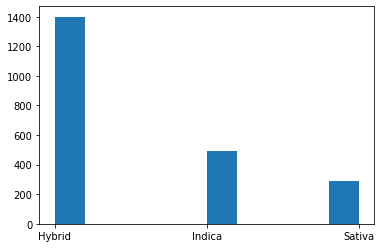

In [ ]:
plt.hist(df["type"]);

We can see here that we have a class imbalance with our data. If we used this data as is, we would get disproportionate results for the minority class(es) due to the imbalance. Therefore, I will implement SMOTE during my preprocessing to synthesize additional data for the minority classes. 

#Preprocessing


In [ ]:
x = df.drop(columns = "type")
y = df["type"]

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42)

In [ ]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown = "ignore", sparse = False)

num_selector = make_column_selector(dtype_include = "number")
cat_selector = make_column_selector(dtype_include = "object")

num_pipe = make_pipeline(scaler)
cat_pipe = make_pipeline(ohe)

num_tupe = (num_pipe, num_selector)
cat_tupe = (cat_pipe, cat_selector)

preprocessor = make_column_transformer(num_tupe, cat_tupe)

In [ ]:
preprocessor.fit(x_train, y_train)

x_train_scale = preprocessor.transform(x_train)
x_test_pro = preprocessor.transform(x_test)

In [ ]:
smote = SMOTE(sampling_strategy = "auto", random_state = 42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_scale, y_train)
y_train_smote.value_counts()

Indica    1046
Hybrid    1046
Sativa    1046
Name: type, dtype: int64

We now have balanced data. 

#Supervised Machine Learning

##Model 1: Decision Tree 

###Model without PCA

In [ ]:
x_train_pro = x_train_smote
y_train = y_train_smote

In [ ]:
#Instantiation
dec_tree = DecisionTreeClassifier(random_state = 42)
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
dec_tree.fit(x_train_pro, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
test_preds = dec_tree.predict(x_test_pro)
train_preds = dec_tree.predict(x_train_pro)

R2

In [ ]:
train_score = dec_tree.score(x_train_pro, y_train)
test_score = dec_tree.score(x_test_pro, y_test)
print(train_score)
print(test_score)

0.9961759082217974
0.676416819012797


Classification Report

In [ ]:
dec_tree_test_cr = classification_report(y_test, test_preds)
dec_tree_train_cr = classification_report(y_train, train_preds)
print(dec_tree_test_cr)
print(dec_tree_train_cr)

              precision    recall  f1-score   support

      Hybrid       0.78      0.71      0.74       354
      Indica       0.60      0.68      0.64       123
      Sativa       0.40      0.50      0.45        70

    accuracy                           0.68       547
   macro avg       0.60      0.63      0.61       547
weighted avg       0.69      0.68      0.68       547

              precision    recall  f1-score   support

      Hybrid       0.99      1.00      0.99      1046
      Indica       1.00      1.00      1.00      1046
      Sativa       1.00      0.99      1.00      1046

    accuracy                           1.00      3138
   macro avg       1.00      1.00      1.00      3138
weighted avg       1.00      1.00      1.00      3138



Confusion Matrix

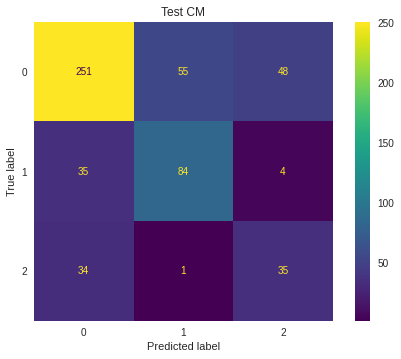

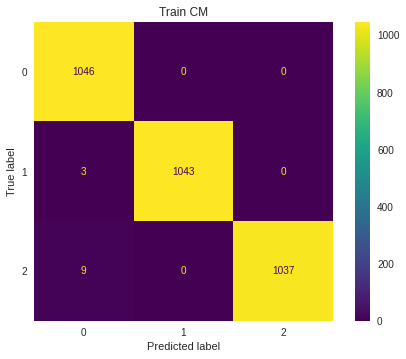

In [ ]:
dec_tree_test_cm = confusion_matrix(y_test, test_preds)
dec_tree_train_cm = confusion_matrix(y_train, train_preds)

dec_tree_test_disp = ConfusionMatrixDisplay(dec_tree_test_cm)
dec_tree_train_disp = ConfusionMatrixDisplay(dec_tree_train_cm)

dec_tree_test_disp.plot()
plt.grid(None)
plt.title("Test CM")
dec_tree_train_disp.plot()
plt.grid(None)
plt.title("Train CM")
plt.style.use("seaborn");

###Model with PCA

In [ ]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)

In [ ]:
pca = PCA(n_components = .95)

pca_pipe = make_pipeline(pca)
pca_pipe.fit(x_train_pro, y_train_le)

Pipeline(steps=[('pca', PCA(n_components=0.95))])

In [ ]:
dec_tree_pca = DecisionTreeClassifier(random_state = 42)
dec_tree_pca.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
dec_tree_pca.fit(x_train_pro, y_train_le)

DecisionTreeClassifier(random_state=42)

In [ ]:
test_preds_pca = dec_tree_pca.predict(x_test_pro)
train_preds_pca = dec_tree_pca.predict(x_train_pro)

R2 Score

In [ ]:
train_score_pca = dec_tree_pca.score(x_train_pro, y_train_le)
test_score_pca = dec_tree_pca.score(x_test_pro, y_test_le)
print(train_score_pca)
print(test_score_pca)

0.9961759082217974
0.676416819012797


Classification Report

In [ ]:
dec_tree_pca_cr_test = classification_report(y_test_le, test_preds_pca)
dec_tree_pca_cr_train = classification_report(y_train_le, train_preds_pca)

print(dec_tree_pca_cr_test)
print(dec_tree_pca_cr_train)

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       354
           1       0.60      0.68      0.64       123
           2       0.40      0.50      0.45        70

    accuracy                           0.68       547
   macro avg       0.60      0.63      0.61       547
weighted avg       0.69      0.68      0.68       547

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1046
           1       1.00      1.00      1.00      1046
           2       1.00      0.99      1.00      1046

    accuracy                           1.00      3138
   macro avg       1.00      1.00      1.00      3138
weighted avg       1.00      1.00      1.00      3138



Confusion Matrix

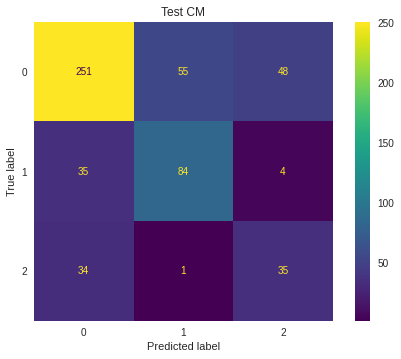

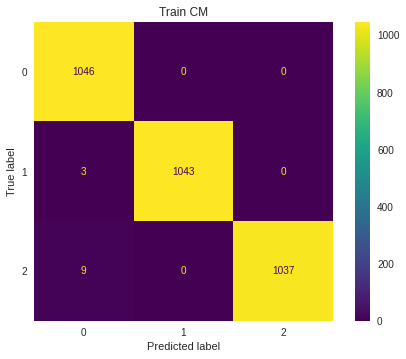

In [ ]:
dec_tree_pca_test_cm = confusion_matrix(y_test_le, test_preds_pca)
dec_tree_pca_train_cm = confusion_matrix(y_train_le, train_preds_pca)

dec_tree_pca_test_disp = ConfusionMatrixDisplay(dec_tree_pca_test_cm)
dec_tree_pca_train_disp = ConfusionMatrixDisplay(dec_tree_pca_train_cm)

dec_tree_pca_test_disp.plot()
plt.grid(None)
plt.title("Test CM")
dec_tree_pca_train_disp.plot()
plt.grid(None)
plt.title("Train CM")
plt.style.use("seaborn")

We do not see any significant change in score between the models with and without PCA. 

##Model 2 - KNN

### Model Without PCA

In [ ]:
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(knn)
knn_pipe.fit(x_train_pro, y_train)

Pipeline(steps=[('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
knn_test_preds = knn_pipe.predict(x_test_pro)
knn_train_preds = knn_pipe.predict(x_train_pro)

Classification Report

In [ ]:
knn_test_classification = classification_report(y_test, knn_test_preds)
knn_train_classification = classification_report(y_train, knn_train_preds)
print(knn_test_classification)
print(knn_train_classification)

              precision    recall  f1-score   support

      Hybrid       0.80      0.56      0.66       354
      Indica       0.54      0.74      0.62       123
      Sativa       0.39      0.71      0.51        70

    accuracy                           0.62       547
   macro avg       0.58      0.67      0.60       547
weighted avg       0.69      0.62      0.63       547

              precision    recall  f1-score   support

      Hybrid       0.93      0.68      0.79      1046
      Indica       0.86      0.96      0.91      1046
      Sativa       0.86      0.98      0.91      1046

    accuracy                           0.87      3138
   macro avg       0.88      0.87      0.87      3138
weighted avg       0.88      0.87      0.87      3138



Confusion Matrix

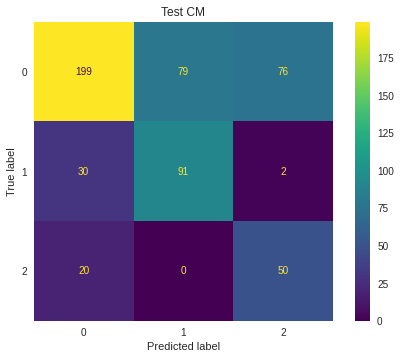

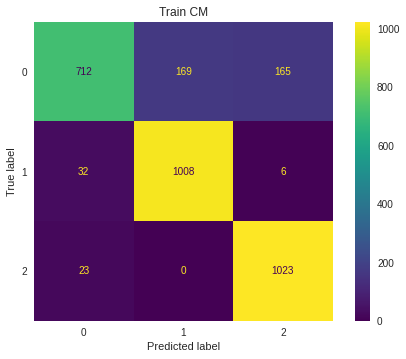

In [ ]:
knn_test_cm = confusion_matrix(y_test, knn_test_preds)
knn_train_cm = confusion_matrix(y_train, knn_train_preds)

knn_test_disp = ConfusionMatrixDisplay(knn_test_cm)
knn_train_disp = ConfusionMatrixDisplay(knn_train_cm)

knn_test_disp.plot()
plt.grid(None)
plt.title("Test CM")
knn_train_disp.plot()
plt.grid(None)
plt.title("Train CM")
plt.style.use("seaborn")

###Model with PCA

In [ ]:
pca_knn = KNeighborsClassifier()
pca_knn_pipe = make_pipeline(pca_pipe, pca_knn)
pca_knn_pipe.fit(x_train_pro, y_train)

Pipeline(steps=[('pipeline', Pipeline(steps=[('pca', PCA(n_components=0.95))])),
                ('kneighborsclassifier', KNeighborsClassifier())])

Classification Report

In [ ]:
%%time
knn_pca_test_preds = pca_knn_pipe.predict(x_test_pro)
knn_pca_train_preds = pca_knn_pipe.predict(x_train_pro)

pca_test_classification = classification_report(y_test, knn_pca_test_preds)
pca_train_classification = classification_report(y_train, knn_pca_train_preds)
print(pca_test_classification)
print(pca_train_classification)

              precision    recall  f1-score   support

      Hybrid       0.81      0.58      0.68       354
      Indica       0.57      0.73      0.64       123
      Sativa       0.37      0.70      0.48        70

    accuracy                           0.63       547
   macro avg       0.58      0.67      0.60       547
weighted avg       0.70      0.63      0.64       547

              precision    recall  f1-score   support

      Hybrid       0.92      0.70      0.80      1046
      Indica       0.86      0.96      0.91      1046
      Sativa       0.87      0.98      0.92      1046

    accuracy                           0.88      3138
   macro avg       0.89      0.88      0.88      3138
weighted avg       0.89      0.88      0.88      3138

CPU times: user 689 ms, sys: 111 ms, total: 800 ms
Wall time: 860 ms


Confusion Matrix

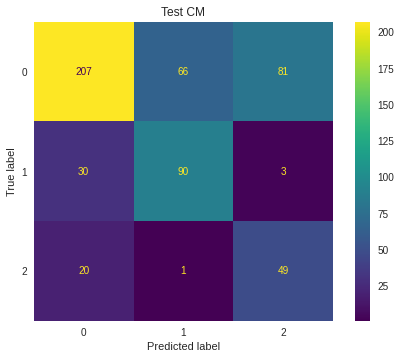

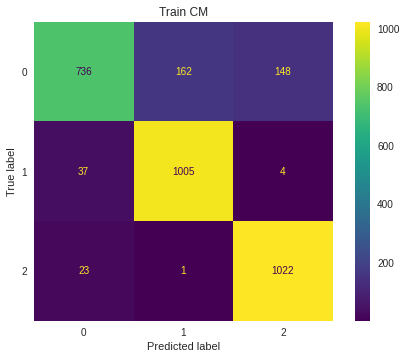

In [ ]:
knn_pca_test_cm = confusion_matrix(y_test, knn_pca_test_preds)
knn_pca_train_cm = confusion_matrix(y_train, knn_pca_train_preds)

knn_pca_test_disp = ConfusionMatrixDisplay(knn_pca_test_cm)
knn_pca_train_disp = ConfusionMatrixDisplay(knn_pca_train_cm)

knn_pca_test_disp.plot()
plt.grid(None)
plt.title("Test CM")
knn_pca_train_disp.plot()
plt.grid(None)
plt.title("Train CM")
plt.style.use("seaborn")

We can see that adding PCA to this KNN model has increased our scores across the board, however does not out perform the Decision Tree model. 

##Model 3 - Random Forest Classifier

###Baseline Model

In [ ]:
rf = RandomForestClassifier(random_state = 42)
rf_pipe = make_pipeline(rf)
rf_pipe.fit(x_train_pro, y_train)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

R2 Score

In [ ]:
rf_test_score = rf_pipe.score(x_test_pro, y_test)
rf_train_score = rf_pipe.score(x_train_pro, y_train)
print(rf_test_score)
print(rf_train_score)

0.7586837294332724
0.9961759082217974


Classification Report

In [ ]:
rf_test_pred = rf_pipe.predict(x_test_pro)
rf_train_pred = rf_pipe.predict(x_train_pro)

rf_test_cr = classification_report(y_test, rf_test_pred)
rf_train_cr = classification_report(y_train, rf_train_pred)
print(rf_test_cr)
print(rf_train_cr)

              precision    recall  f1-score   support

      Hybrid       0.81      0.82      0.82       354
      Indica       0.72      0.68      0.70       123
      Sativa       0.56      0.57      0.57        70

    accuracy                           0.76       547
   macro avg       0.70      0.69      0.70       547
weighted avg       0.76      0.76      0.76       547

              precision    recall  f1-score   support

      Hybrid       0.99      1.00      0.99      1046
      Indica       1.00      1.00      1.00      1046
      Sativa       1.00      0.99      1.00      1046

    accuracy                           1.00      3138
   macro avg       1.00      1.00      1.00      3138
weighted avg       1.00      1.00      1.00      3138



In [ ]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('randomforestclassifier',
   RandomForestClassifier(random_state=42))],
 'verbose': False,
 'randomforestclassifier': RandomForestClassifier(random_state=42),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__n_jobs': None,
 'randomforestclassifier__oob_score': False,
 'randomforestclassifier__random_state': 42,
 'randomforestclassifier__verbose': 0,
 'randomforestclas

###Gridsearch CV

In [ ]:
#Param Grid
param_grid = {"randomforestclassifier__max_depth": range(50, 60), 
              "randomforestclassifier__min_samples_split": range(1, 5), 
              "randomforestclassifier__min_samples_leaf": range(1, 5), 
              "randomforestclassifier__bootstrap" : [True, False], 
              "randomforestclassifier__n_estimators" : range(100, 105), 
              "randomforestclassifier__max_features" : ["auto", "sqrt"]}

In [ ]:
rf_gridsearch = GridSearchCV(rf_pipe, param_grid)

rf_gridsearch.fit(x_train_pro, y_train)
print("Best Params")
print(rf_gridsearch.best_params_)
best_pipe = rf_gridsearch.best_estimator_
print(f"Accuracy of best RF Model is: {best_pipe.score(x_test_pro, y_test)}");

Best Params
{'randomforestclassifier__bootstrap': False, 'randomforestclassifier__max_depth': 50, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 100}
Accuracy of best RF Model is: 0.7678244972577697


In [ ]:
new_rf = RandomForestClassifier(n_estimators = 100, max_features = "auto", 
                                bootstrap = False, max_depth = 50, min_samples_leaf = 1, 
                                min_samples_split = 3, random_state = 42)
new_rf.fit(x_train_pro, y_train)

RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_split=3,
                       random_state=42)

R2 Score

In [ ]:
new_rf_test_score = new_rf.score(x_test_pro, y_test)
new_rf_train_score = new_rf.score(x_train_pro, y_train)
print(new_rf_test_score)
print(new_rf_train_score)

0.7678244972577697
0.9961759082217974


Classification Report

In [ ]:
rf_train_pred2 = new_rf.predict(x_train_pro)
rf_test_pred2 = new_rf.predict(x_test_pro)

new_rf_test_cr = classification_report(y_test, rf_test_pred2)
new_rf_train_cr = classification_report(y_train, rf_train_pred2)
print(new_rf_test_cr)
print(new_rf_train_cr)

              precision    recall  f1-score   support

      Hybrid       0.80      0.85      0.83       354
      Indica       0.76      0.67      0.71       123
      Sativa       0.58      0.54      0.56        70

    accuracy                           0.77       547
   macro avg       0.71      0.69      0.70       547
weighted avg       0.76      0.77      0.77       547

              precision    recall  f1-score   support

      Hybrid       0.99      1.00      0.99      1046
      Indica       1.00      1.00      1.00      1046
      Sativa       1.00      0.99      1.00      1046

    accuracy                           1.00      3138
   macro avg       1.00      1.00      1.00      3138
weighted avg       1.00      1.00      1.00      3138



Confusion Matrix

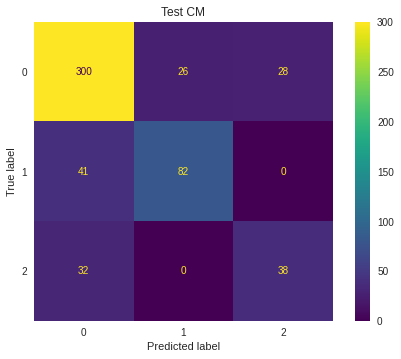

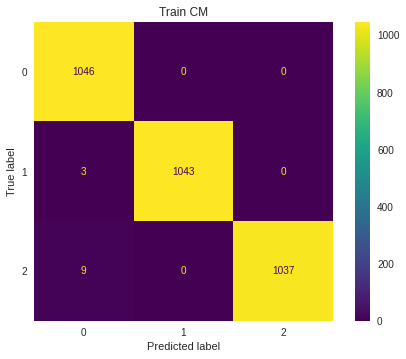

In [ ]:
rf_test_cm = confusion_matrix(y_test, rf_test_pred2)
rf_train_cm = confusion_matrix(y_train, rf_train_pred2)

rf_test_disp = ConfusionMatrixDisplay(rf_test_cm)
rf_train_disp = ConfusionMatrixDisplay(rf_train_cm)

rf_test_disp.plot()
plt.grid(None)
plt.title("Test CM")
rf_train_disp.plot()
plt.grid(None)
plt.title("Train CM")
plt.style.use("seaborn")

After using GridSearch CV to hypertune the Random Forest model, we have achieved our highest r2 score so far: 76.9%. This exceeds the minimum requirement to make data-informed decisions.

#Unsupervised Machine Learning 

##KMeans Clustering

In [ ]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown = "ignore", sparse = False)

num_selector = make_column_selector(dtype_include = "number")
cat_selector = make_column_selector(dtype_include = "object")

num_pipe = make_pipeline(scaler)
cat_pipe = make_pipeline(ohe)

num_tupe = (num_pipe, num_selector)
cat_tupe = (cat_pipe, cat_selector)

preprocessor = make_column_transformer(num_tupe, cat_tupe)

In [ ]:
scaled_df = preprocessor.fit_transform(df)

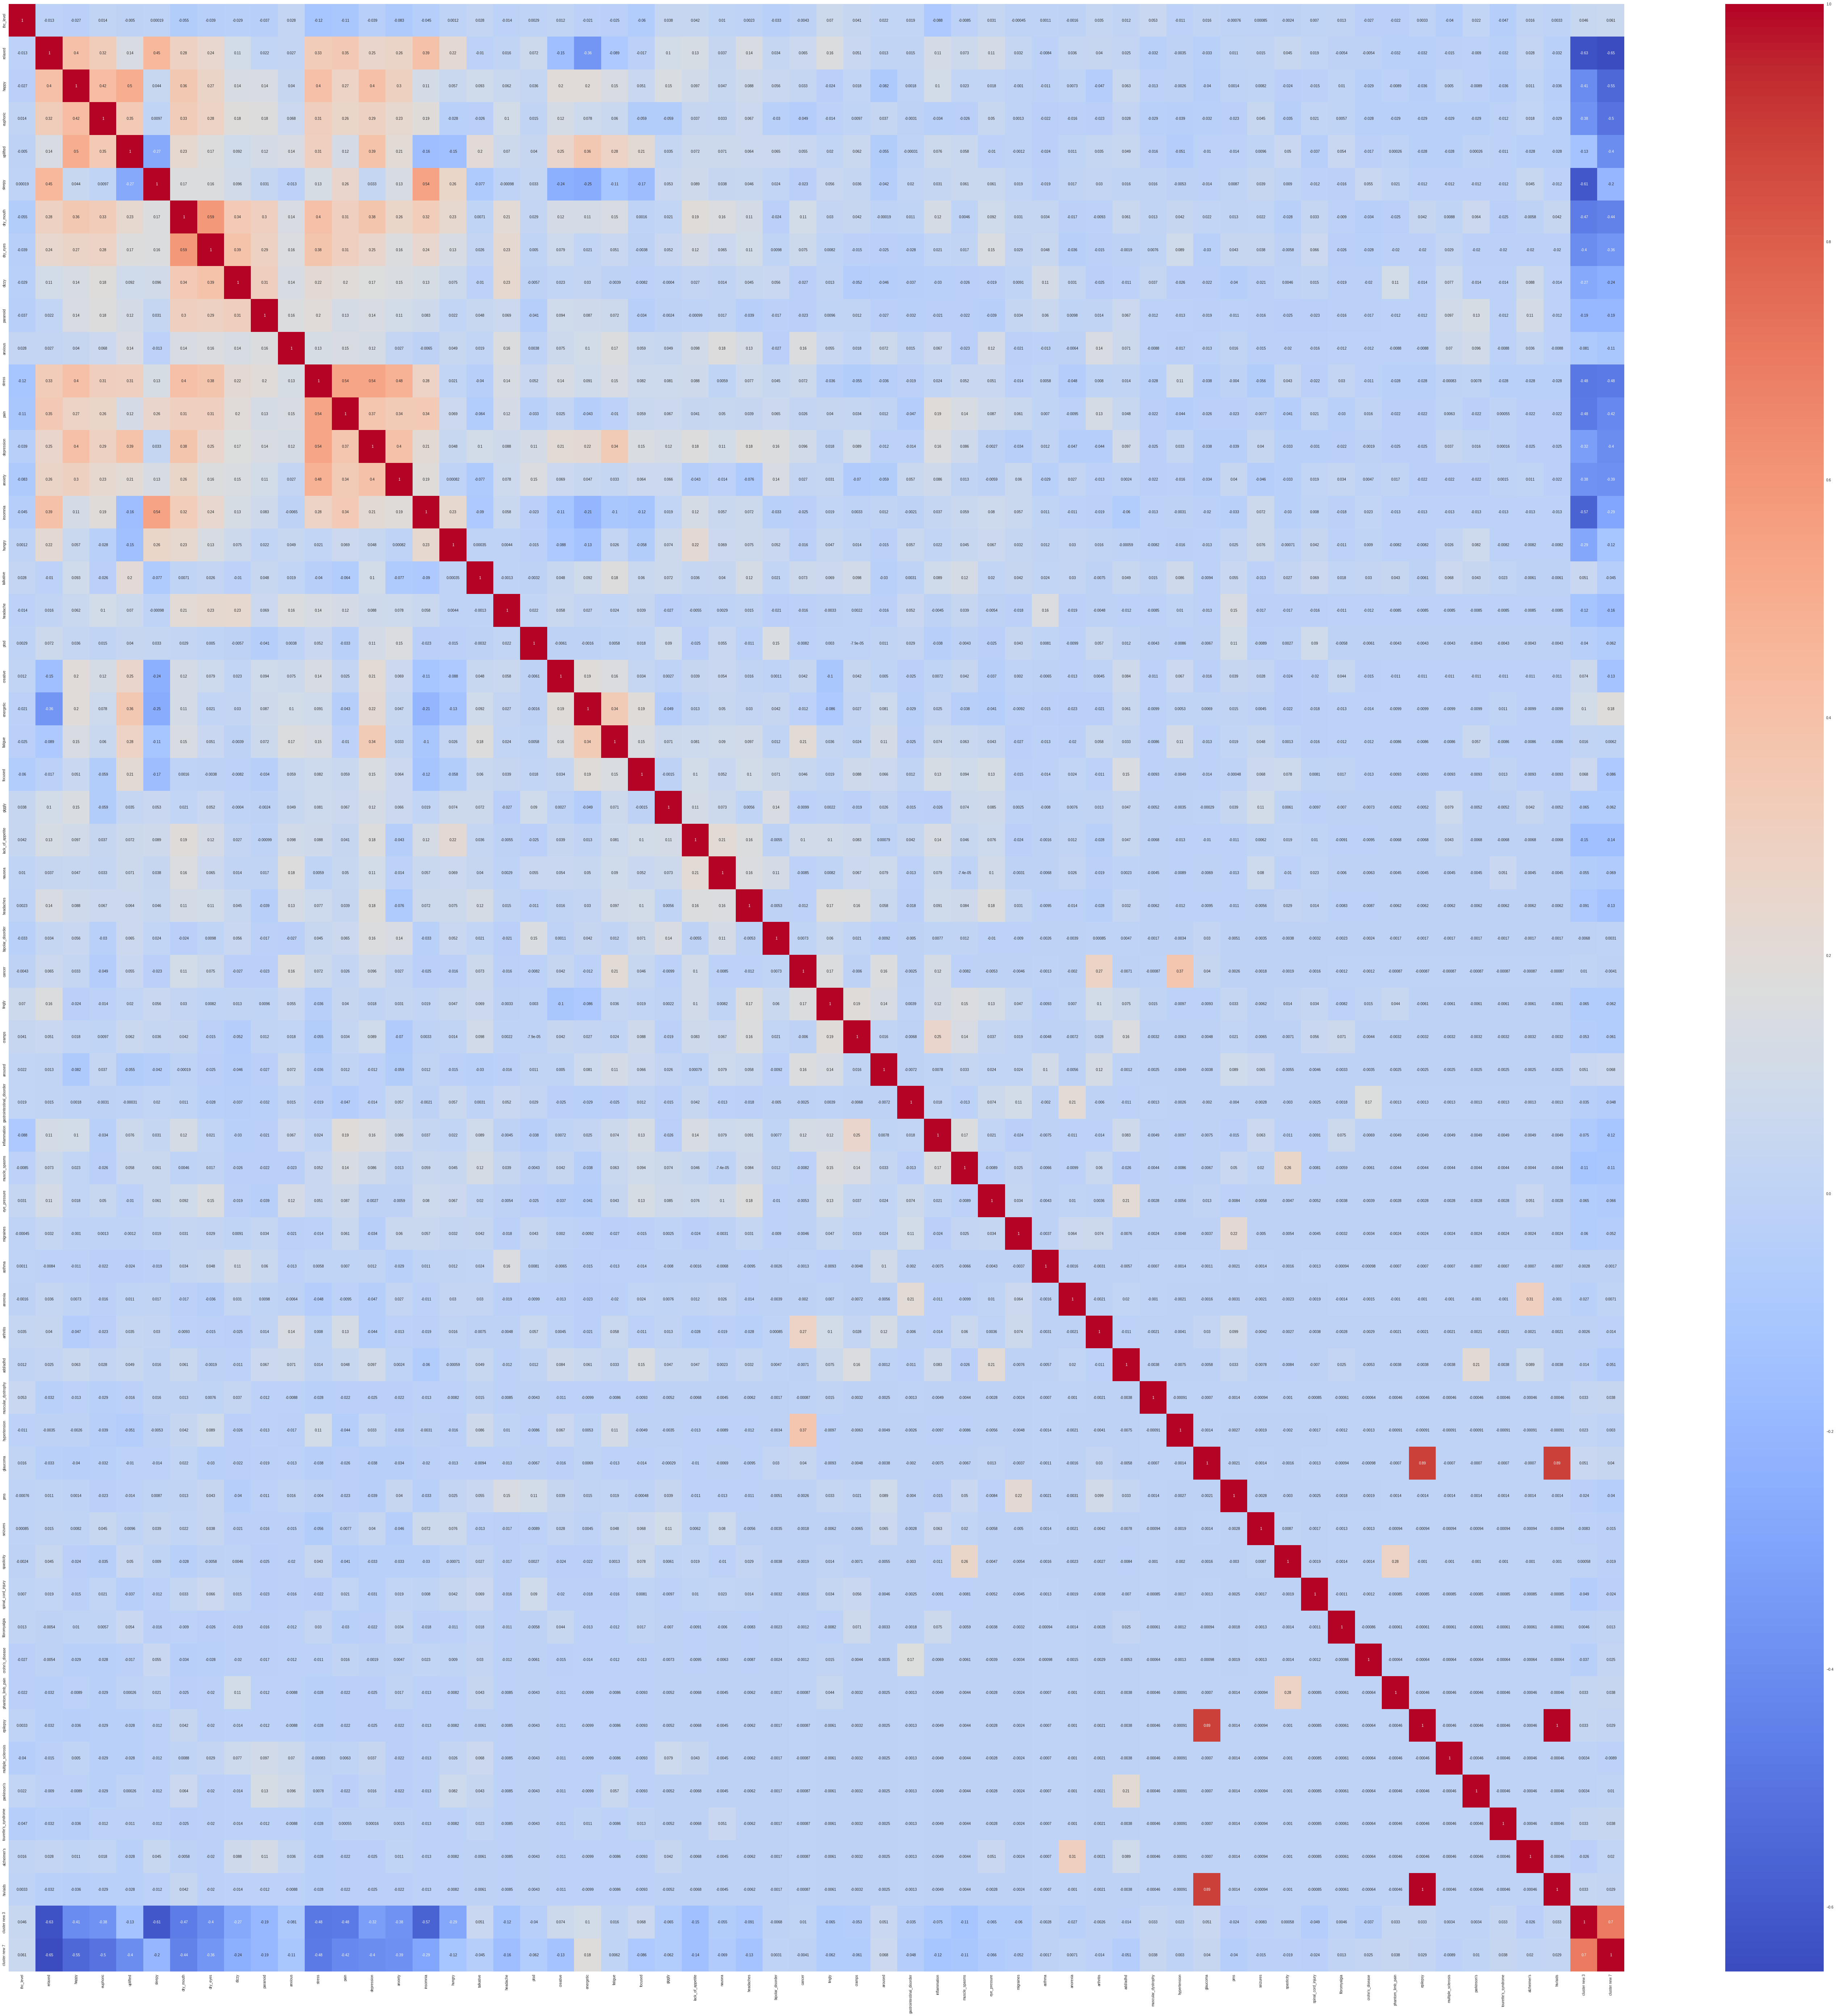

In [ ]:
corr = df.corr()
plt.figure(figsize = (100, 100))
sns.heatmap(corr, cmap = "coolwarm", annot = True);

Elbow Plot of Inertia

In [ ]:
inertias = []

for k in range(2, 11):
  kmeans = KMeans(n_clusters = k, random_state = 42)
  kmeans.fit(scaled_df)
  inertias.append(kmeans.inertia_)

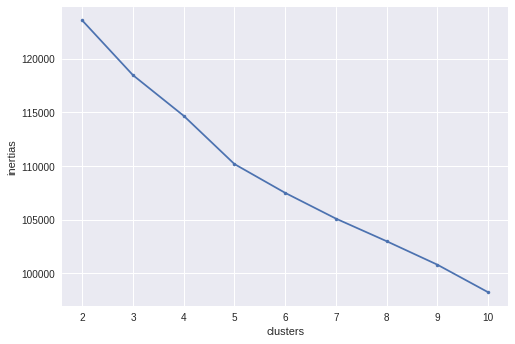

In [ ]:
plt.plot(range(2, 11), inertias, marker = ".")
plt.xlabel("clusters")
plt.ylabel("inertias");

In [ ]:
silhouette_scores = []

for i in range(2, 11):
  kmeans = KMeans(n_clusters = i, random_state = 42)
  kmeans.fit(scaled_df)
  silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))

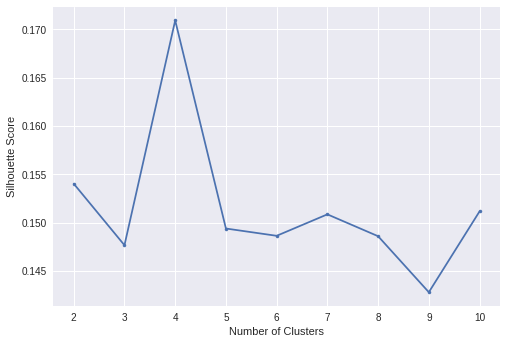

In [ ]:
plt.plot(range(2, 11), silhouette_scores, marker = ".")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score");

Based on the results of our Silouette Score and our Inertia Plot, we will test run 3 to 8 clusters. 

In [ ]:
kmeans3 = KMeans(n_clusters = 3, random_state = 42)
kmeans4 = KMeans(n_clusters = 4, random_state = 42)
kmeans5 = KMeans(n_clusters = 5, random_state = 42)
kmeans6 = KMeans(n_clusters = 6, random_state = 42)
kmeans7 = KMeans(n_clusters = 7, random_state = 42)
kmeans8 = KMeans(n_clusters = 8, random_state = 42)

kmeans3.fit(scaled_df)
kmeans4.fit(scaled_df)
kmeans5.fit(scaled_df)
kmeans6.fit(scaled_df)
kmeans7.fit(scaled_df)
kmeans8.fit(scaled_df);

###Visualizations

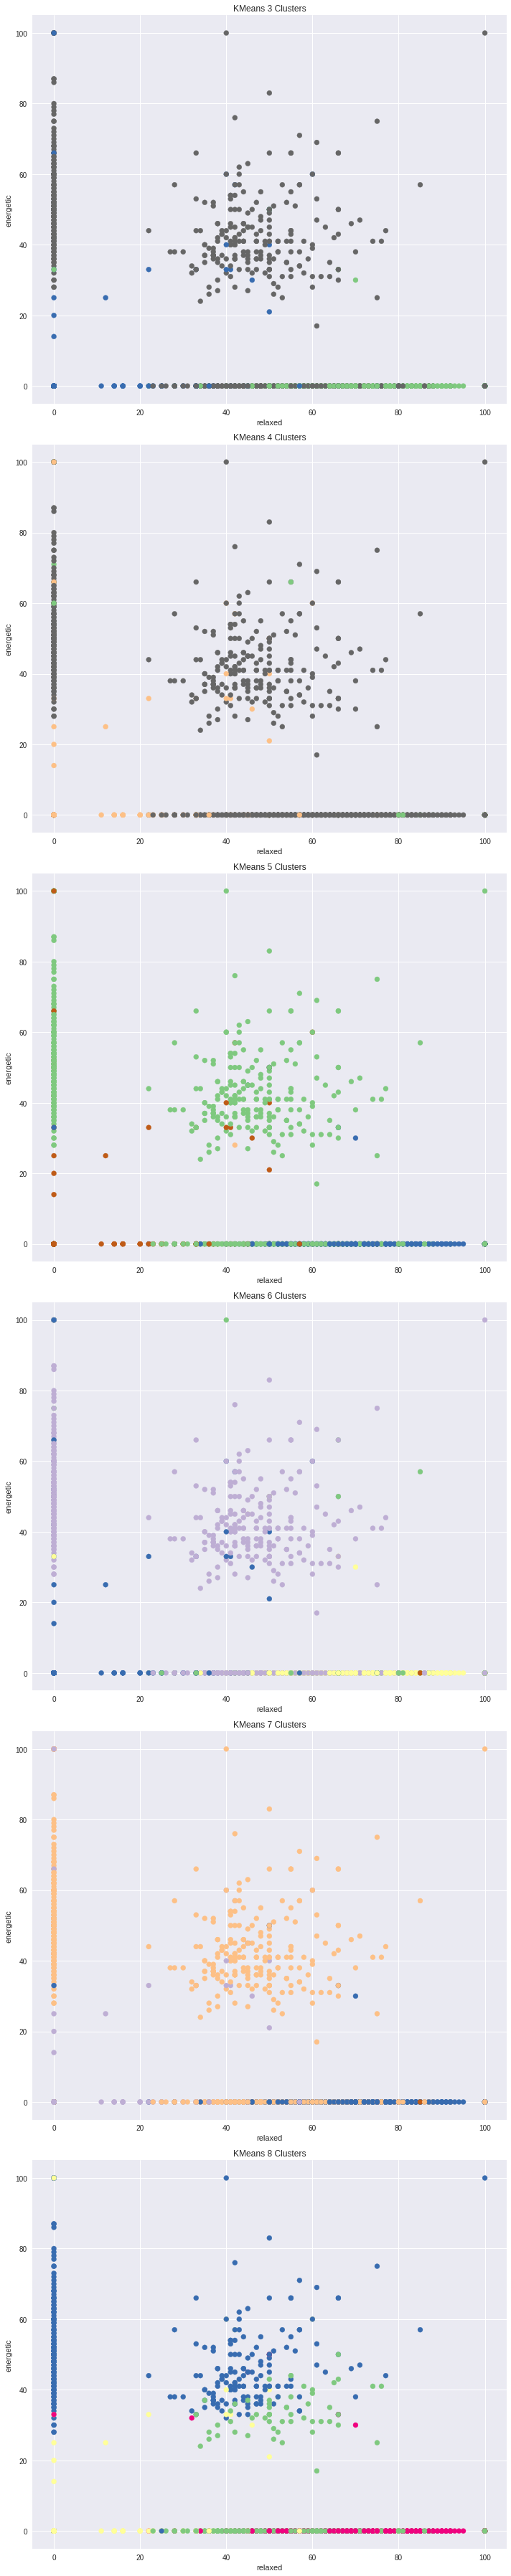

In [ ]:
df["cluster3"] = kmeans3.labels_
df["cluster4"] = kmeans4.labels_
df["cluster5"] = kmeans5.labels_
df["cluster6"] = kmeans6.labels_
df["cluster7"] = kmeans7.labels_
df["cluster8"] = kmeans8.labels_

fig, axes = plt.subplots(6, 1, figsize = (10, 50))

axes[0].scatter(df["relaxed"], df["energetic"], c = df["cluster3"], cmap = "Accent")
axes[0].set_xlabel("relaxed")
axes[0].set_ylabel("energetic")
axes[0].set_title("KMeans 3 Clusters")

axes[1].scatter(df["relaxed"], df["energetic"], c = df["cluster4"], cmap = "Accent")
axes[1].set_xlabel("relaxed")
axes[1].set_ylabel("energetic")
axes[1].set_title("KMeans 4 Clusters")

axes[2].scatter(df["relaxed"], df["energetic"], c = df["cluster5"], cmap = "Accent")
axes[2].set_xlabel("relaxed")
axes[2].set_ylabel("energetic")
axes[2].set_title("KMeans 5 Clusters")

axes[3].scatter(df["relaxed"], df["energetic"], c = df["cluster6"], cmap = "Accent")
axes[3].set_xlabel("relaxed")
axes[3].set_ylabel("energetic")
axes[3].set_title("KMeans 6 Clusters")

axes[4].scatter(df["relaxed"], df["energetic"], c = df["cluster7"], cmap = "Accent")
axes[4].set_xlabel("relaxed")
axes[4].set_ylabel("energetic")
axes[4].set_title("KMeans 7 Clusters")

axes[5].scatter(df["relaxed"], df["energetic"], c = df["cluster8"], cmap = "Accent")
axes[5].set_xlabel("relaxed")
axes[5].set_ylabel("energetic")
axes[5].set_title("KMeans 8 Clusters")

plt.tight_layout();

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2185 entries, 0 to 4761
Data columns (total 68 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   type                       2185 non-null   object 
 1   thc_level                  2185 non-null   float64
 2   most_common_terpene        2185 non-null   object 
 3   relaxed                    2185 non-null   float64
 4   happy                      2185 non-null   float64
 5   euphoric                   2185 non-null   float64
 6   uplifted                   2185 non-null   float64
 7   sleepy                     2185 non-null   float64
 8   dry_mouth                  2185 non-null   float64
 9   dry_eyes                   2185 non-null   float64
 10  dizzy                      2185 non-null   float64
 11  paranoid                   2185 non-null   float64
 12  anxious                    2185 non-null   float64
 13  stress                     2185 non-null   float

In [ ]:
df.drop(columns = ["cluster3", "cluster4", "cluster5", "cluster6", "cluster7", "cluster8" ], inplace = True)

###KMeans 3

In [ ]:
kmeans_3 = KMeans(n_clusters = 3, random_state = 42)
kmeans_3.fit(scaled_df)
df["cluster new 3"] = kmeans_3.labels_
cluster_groups3 = df.groupby("cluster new 3", as_index = False).mean()
cluster_groups3

,cluster new 3,thc_level,relaxed,happy,euphoric,uplifted,sleepy,dry_mouth,dry_eyes,dizzy,...,fibromyalgia,crohn's_disease,phantom_limb_pain,epilepsy,multiple_sclerosis,parkinson's,tourette's_syndrome,alzheimer's,hiv/aids,cluster new 7
0,0,18.482906,68.958689,47.407407,39.609687,24.000000,35.464387,24.490028,13.987179,5.263533,...,0.00000,0.082621,0.000000,0.000000,0.000000,0.000000,0.000000,0.019943,0.000000,0.811966
1,1,19.037209,12.902326,10.886047,6.737209,7.055814,2.876744,1.376744,0.811628,0.404651,...,0.00000,0.000000,0.076744,0.116279,0.000000,0.000000,0.046512,0.000000,0.116279,5.953488
2,2,18.232669,43.736942,55.024691,43.113010,48.974359,0.587844,21.247863,11.253561,4.420703,...,0.05698,0.000000,0.000000,0.000000,0.023742,0.031339,0.000000,0.000000,0.000000,1.056980


In [ ]:
fig, axes = plt.subplots(9, 7, figsize = (100,100))
axes = axes.ravel()

for i, col in enumerate(cluster_groups3.columns[1:]):
  axes[i].bar(cluster_groups3["cluster new 3"], cluster_groups3[col])
  axes[i].set_title(f"Mean {col}")
  plt.tight_layout();

###Kmeans 7

In [ ]:
kmeans_7 = KMeans(n_clusters = 7, random_state = 42)
kmeans_7.fit(scaled_df)
df["cluster new 7"] = kmeans_7.labels_
cluster_groups7 = df.groupby("cluster new 7", as_index = False).mean()
cluster_groups7

,cluster new 7,thc_level,relaxed,happy,euphoric,uplifted,sleepy,dry_mouth,dry_eyes,dizzy,...,fibromyalgia,crohn's_disease,phantom_limb_pain,epilepsy,multiple_sclerosis,parkinson's,tourette's_syndrome,alzheimer's,hiv/aids,cluster new 3
0,0,19.000000,71.428571,28.571429,14.285714,42.857143,42.857143,50.000000,35.714286,7.142857,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,1.142857
1,1,19.037296,13.009324,10.911422,6.752914,7.072261,2.883450,1.263403,0.813520,0.328671,...,0.000000,0.076923,0.0,0.0,0.000000,0.000000,0.04662,0.0,0.0,0.997669
2,2,18.233047,43.585482,55.048711,43.213945,48.948424,0.591213,21.092646,11.174785,4.398281,...,0.057307,0.000000,0.0,0.0,0.023878,0.031519,0.00000,0.0,0.0,2.000000
3,3,18.486331,68.987050,47.640288,39.854676,23.956835,35.188489,24.558273,13.969784,5.247482,...,0.000000,0.035971,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000
4,4,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,50.0,0.000000,0.000000,0.00000,0.0,50.0,1.000000
5,5,17.600000,70.200000,48.400000,32.000000,37.200000,21.400000,12.800000,2.000000,9.600000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,2.8,0.0,0.800000
6,6,15.000000,0.000000,33.000000,0.000000,33.000000,33.000000,0.000000,0.000000,33.000000,...,0.000000,0.000000,33.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,1.000000


In [ ]:
fig, axes = plt.subplots(9, 7, figsize = (100, 100))
axes = axes.ravel()

for i, col in enumerate(cluster_groups7.columns[1:]):
  axes[i].bar(cluster_groups7["cluster new 7"], cluster_groups7[col])
  axes[i].set_title(f"Mean {col}")
  plt.tight_layout();

#Conclusion

asd